In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Reshape, GlobalAveragePooling1D,MaxPooling1D,Dense,AveragePooling1D
from keras.models import Model
from keras import layers

from keras.layers import Layer
from keras import backend as K


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv1d_bn(x,
              filters,
              kernel_size,
              padding='same',
              strides=1,
              name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 1
    x = Conv1D(
        filters, kernel_size,
        strides=strides,
        padding=str(padding),
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3():
    # Determine proper input shape
    input_shape = (42,1)
    x_input = Input(shape=input_shape)
    channel_axis = -1

    x = conv1d_bn(x_input, 32, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 32, 3, padding='valid')
    x = conv1d_bn(x, 64, 3, padding='valid')
    x = MaxPooling1D(3, strides=2, name="block1_pool")(x)
    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')

    branch5x5 = conv1d_bn(x, 48,1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')
    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 32, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')
    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64,5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64, 1,padding='same')

    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv1d_bn(x, 384, 3, strides=2, padding='valid')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(
        branch3x3dbl, 96, 3, strides=2, padding='valid')

    branch_pool = MaxPooling1D(3, strides=2)(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    branch7x7 = conv1d_bn(x, 128, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 128, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 128, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 128, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 128, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 128, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv1d_bn(x, 192, 1,padding='same')

        branch7x7 = conv1d_bn(x, 160, 1,padding='same')
        branch7x7 = conv1d_bn(branch7x7, 160, 1,padding='same')
        branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

        branch7x7dbl = conv1d_bn(x, 160, 1,padding='same')
        branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
        branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 1,padding='same')
        branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
        branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

        branch_pool = AveragePooling1D(
            3, strides=1, padding='same')(x)
        branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    branch7x7 = conv1d_bn(x, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 192, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv1d_bn(x, 192, 1,padding='same')
    branch3x3 = conv1d_bn(branch3x3, 320, 3,
                          strides=2, padding='valid')

    branch7x7x3 = conv1d_bn(x, 192, 1,padding='same')
    branch7x7x3 = conv1d_bn(branch7x7x3, 192, 1,padding='same')
    branch7x7x3 = conv1d_bn(branch7x7x3, 192, 7,padding='same')
    branch7x7x3 = conv1d_bn(
        branch7x7x3, 192, 3, strides=2, padding='valid')

    branch_pool = MaxPooling1D(3, strides=2)(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv1d_bn(x, 320, 1,padding='same')

        branch3x3 = conv1d_bn(x, 384, 1,padding='same')
        branch3x3_1 = conv1d_bn(branch3x3, 384, 1,padding='same')
        branch3x3_2 = conv1d_bn(branch3x3, 384, 3,padding='same')
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv1d_bn(x, 448, 1,padding='same')
        branch3x3dbl = conv1d_bn(branch3x3dbl, 384, 3,padding='same')
        branch3x3dbl_1 = conv1d_bn(branch3x3dbl, 384, 1,padding='same')
        branch3x3dbl_2 = conv1d_bn(branch3x3dbl, 384, 3,padding='same')
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling1D(
            3, strides=1, padding='same')(x)
        branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)

    # Create model.
    model = Model(x_input, x, name='inception_v3')
    return model


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

model = InceptionV3()
lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 32)      60          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 20, 32)       0           ['batch_normalization[

                                                                  'activation_9[0][0]']           
                                                                                                  
 conv1d_13 (Conv1D)             (None, 7, 64)        16384       ['mixed0[0][0]']                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 7, 64)       21          ['conv1d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 7, 64)        0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv1d_11 (Conv1D)             (None, 7, 48)        12288       ['mixed0[0][0]']                 
          

 conv1d_17 (Conv1D)             (None, 7, 64)        18432       ['mixed1[0][0]']                 
                                                                                                  
 conv1d_19 (Conv1D)             (None, 7, 64)        15360       ['activation_18[0][0]']          
                                                                                                  
 conv1d_22 (Conv1D)             (None, 7, 96)        27648       ['activation_21[0][0]']          
                                                                                                  
 conv1d_23 (Conv1D)             (None, 7, 64)        18432       ['average_pooling1d_2[0][0]']    
                                                                                                  
 batch_normalization_17 (BatchN  (None, 7, 64)       21          ['conv1d_17[0][0]']              
 ormalization)                                                                                    
          

 conv1d_34 (Conv1D)             (None, 3, 128)       16384       ['activation_33[0][0]']          
                                                                                                  
 batch_normalization_29 (BatchN  (None, 3, 128)      9           ['conv1d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 128)      9           ['conv1d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_29 (Activation)     (None, 3, 128)       0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 activatio

C:\Users\PC\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 batch_normalization_43 (BatchN  (None, 3, 160)      9           ['conv1d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_43 (Activation)     (None, 3, 160)       0           ['batch_normalization_43[0][0]'] 
                                                                                                  
 conv1d_39 (Conv1D)             (None, 3, 160)       122880      ['mixed4[0][0]']                 
                                                                                                  
 conv1d_44 (Conv1D)             (None, 3, 160)       25600       ['activation_43[0][0]']          
                                                                                                  
 batch_normalization_39 (BatchN  (None, 3, 160)      9           ['conv1d_39[0][0]']              
 ormalizat

 conv1d_49 (Conv1D)             (None, 3, 160)       122880      ['mixed5[0][0]']                 
                                                                                                  
 conv1d_54 (Conv1D)             (None, 3, 160)       25600       ['activation_53[0][0]']          
                                                                                                  
 batch_normalization_49 (BatchN  (None, 3, 160)      9           ['conv1d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_54 (BatchN  (None, 3, 160)      9           ['conv1d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_64 (BatchN  (None, 3, 192)      9           ['conv1d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_59 (Activation)     (None, 3, 192)       0           ['batch_normalization_59[0][0]'] 
                                                                                                  
 activation_64 (Activation)     (None, 3, 192)       0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv1d_60 (Conv1D)             (None, 3, 192)       36864       ['activation_59[0][0]']          
          

 activation_68 (Activation)     (None, 3, 192)       0           ['batch_normalization_68[0][0]'] 
                                                                                                  
 activation_72 (Activation)     (None, 3, 192)       0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 conv1d_69 (Conv1D)             (None, 1, 320)       184320      ['activation_68[0][0]']          
                                                                                                  
 conv1d_73 (Conv1D)             (None, 1, 192)       110592      ['activation_72[0][0]']          
                                                                                                  
 batch_normalization_69 (BatchN  (None, 1, 320)      3           ['conv1d_69[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_82 (BatchN  (None, 1, 192)      3           ['conv1d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_74 (Activation)     (None, 1, 320)       0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 768)       0           ['activation_76[0][0]',          
                                                                  'activation_77[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 1, 768)       0           ['activation_80[0][0]',          
                                                                  'activation_81[0][0]']          
          

                                                                  'activation_86[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 768)       0           ['activation_89[0][0]',          
                                                                  'activation_90[0][0]']          
                                                                                                  
 activation_91 (Activation)     (None, 1, 192)       0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 mixed10 (Concatenate)          (None, 1, 2048)      0           ['activation_83[0][0]',          
                                                                  'mixed9_1[0][0]',               
                                                                  'concatenate_1[0][0]',          
          

In [5]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=32,epochs=600, callbacks=[early_stopping,lr_scheduler])


Epoch 1/600
32/32 [==============================] - 41s 646ms/step - loss: 0.7289 - accuracy: 0.6125 - val_loss: 0.7355 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/600
32/32 [==============================] - 15s 462ms/step - loss: 0.5536 - accuracy: 0.7260 - val_loss: 0.8684 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 3/600
32/32 [==============================] - 13s 399ms/step - loss: 0.4017 - accuracy: 0.8229 - val_loss: 1.4142 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 4/600
32/32 [==============================] - 13s 400ms/step - loss: 0.3508 - accuracy: 0.8405 - val_loss: 2.0326 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 5/600
32/32 [==============================] - 16s 497ms/step - loss: 0.2847 - accuracy: 0.8699 - val_loss: 2.6271 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 6/600
32/32 [==============================] - 15s 469ms/step - loss: 0.1989 - accuracy: 0.9247 - val_loss: 3.7227 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 7/600
32/32 [===============

Epoch 51/600
32/32 [==============================] - 18s 558ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 2.3870 - val_accuracy: 0.7091 - lr: 5.0000e-05
Epoch 52/600
32/32 [==============================] - 18s 564ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 2.5419 - val_accuracy: 0.7212 - lr: 5.0000e-05
Epoch 53/600
32/32 [==============================] - 19s 604ms/step - loss: 0.0077 - accuracy: 0.9990 - val_loss: 2.1138 - val_accuracy: 0.7121 - lr: 5.0000e-05
Epoch 54/600
32/32 [==============================] - 18s 567ms/step - loss: 5.7737e-04 - accuracy: 1.0000 - val_loss: 2.1582 - val_accuracy: 0.7152 - lr: 5.0000e-05
Epoch 55/600
32/32 [==============================] - 18s 577ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 2.2237 - val_accuracy: 0.7152 - lr: 5.0000e-05
Epoch 56/600
32/32 [==============================] - 19s 586ms/step - loss: 0.0675 - accuracy: 0.9775 - val_loss: 4.3073 - val_accuracy: 0.3879 - lr: 5.0000e-05
Epoch 57/600
32/32 [====

<Axes: >

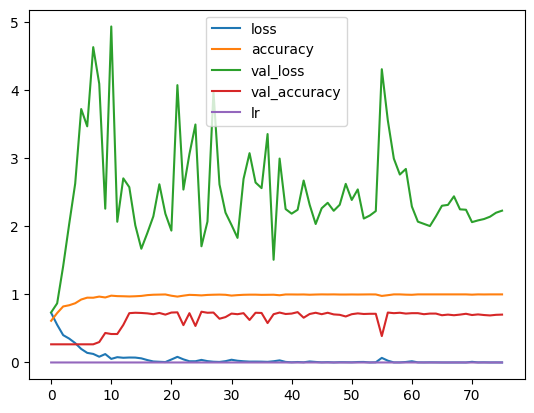

In [6]:
losses = pd.DataFrame(history.history)
losses.plot()

In [7]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       242
           1       0.54      0.34      0.42        88

    accuracy                           0.75       330
   macro avg       0.66      0.62      0.63       330
weighted avg       0.72      0.75      0.73       330

